In [1]:
## 施設名のエンコーディング
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

ModuleNotFoundError: No module named 'torch'

In [ ]:
class FacilityDataset(Dataset):
    def __init__(self, facilities, targets=None):
        self.facilities = facilities
        self.targets = targets
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.max_len = 128

    def __len__(self):
        return len(self.facilities)

    def __getitem__(self, idx):
        facility = str(self.facilities[idx])
        inputs = self.tokenizer.encode_plus(
            facility,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        if self.targets is not None:
            return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
                'targets': torch.tensor(self.targets[idx], dtype=torch.float)
            }
        else:
            return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)
            }
            
train_df = pd.read_csv('train.csv')
facilities = train_df['FacilityName'].values
train_dataset = FacilityDataset(facilities, train_df['GHG_Direct_Emissions_14_in_metric_tons'].values)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
class BertRegressor(nn.Module):
    def __init__(self):
        super(BertRegressor, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, 1)
    
    def forward(self, ids, mask, token_type_ids):
        outputs = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]  # BERTのプーリングされた出力を取得
        x = self.dropout(pooled_output)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        return x
    
def rmsle_loss(y_pred, y_true):
    return torch.sqrt(torch.mean((torch.log1p(y_pred) - torch.log1p(y_true)) ** 2))

In [ ]:
model = BertRegressor()
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = optim.Adam(model.parameters(), lr=1e-5)

def train_model(model, train_loader, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        for batch in train_loader:
            ids = batch['ids'].to('cuda' if torch.cuda.is_available() else 'cpu')
            mask = batch['mask'].to('cuda' if torch.cuda.is_available() else 'cpu')
            token_type_ids = batch['token_type_ids'].to('cuda' if torch.cuda.is_available() else 'cpu')
            targets = batch['targets'].to('cuda' if torch.cuda.is_available() else 'cpu')

            outputs = model(ids, mask, token_type_ids)
            loss = rmsle_loss(outputs, targets.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

train_model(model, train_loader, optimizer, num_epochs=5)

## 本題

In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor


from sklearn.model_selection import KFold
from sklearn.metrics import *

import gc
gc.collect()

import os

def root_mean_squared_log_error(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [114]:
train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv')
del train_df['Unnamed: 0'], test_df['Unnamed: 0']
del train_df["County"], test_df["County"]
del train_df["FacilityName"], test_df["FacilityName"]

In [115]:
train_df.sample(5)

,Latitude,Longitude,LocationAddress,City,State,ZIP,FIPScode,PrimaryNAICS,SecondPrimaryNAICS,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons
2453,37.614900,-99.323600,NaN,GREENSBURG,KS,67054,20097.0,486210,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,1.153430e+05,19811.647093,5.266917e+04,29198.531119,8.495169e+03
1740,38.544521,-76.685785,25100 CHALK POINT RD,AQUASCO,MD,20608,24033.0,221112,NaN,Power Plants,14061.746824,19693.543745,12887.599086,8966.128528,6.016654e+04,51747.839012,5.651287e+04,35675.648395,9.425643e+04
517,41.657733,-111.843444,1445 OLD MAIN HILL,LOGAN,UT,84322,49005.0,611310,NaN,Other,NaN,NaN,NaN,NaN,9.521242e+04,110692.050664,2.399951e+05,59723.773283,1.057828e+05
4292,32.205187,-94.153666,"32.205187¿¿, -94.153666¿¿",CARTHAGE,TX,75633,48365.0,486210,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,6.678755e+04,57040.888492,4.179069e+04,14965.861271,2.197270e+04
1307,33.676123,-116.180559,"87-011 44TH AVE LANDFILL RD, N",COACHELLA,CA,92236,6065.0,562212,NaN,Waste,NaN,NaN,NaN,NaN,2.470294e+06,75600.242941,1.713903e+06,488176.537353,1.388069e+06


In [116]:
# primaryNAICSCodeを文字列に変換
train_df['PrimaryNAICS'] = train_df['PrimaryNAICS'].astype(str)
test_df['PrimaryNAICS'] = test_df['PrimaryNAICS'].astype(str)

# 5文字に変換
train_df['PrimaryNAICS'] = train_df['PrimaryNAICS'].apply(lambda x: x[:5])
test_df['PrimaryNAICS'] = test_df['PrimaryNAICS'].apply(lambda x: x[:5])

train_df.head()

,Latitude,Longitude,LocationAddress,City,State,ZIP,FIPScode,PrimaryNAICS,SecondPrimaryNAICS,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons
0,40.141389,-87.581111,915 N MICHIGAN AVE,DANVILLE,IL,61832,17183.0,32612,NaN,Other,31566.709644,26644.986107,23410.379903,31809.857564,64816.958901,36588.744606,37907.936721,45598.125851,52973.139946
1,38.475305,-81.278957,200 RIVER HAVEN ROAD,CLENDENIN,WV,25045-9304,54039.0,48621,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,55507.543666,72387.334115,58225.196089,76376.547318,55910.066617
2,39.299820,-80.857170,3041 LONG RUN RD.,GREENWOOD,WV,26415,54085.0,21111,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55679.543214
3,35.490363,-119.042957,10245 OILFIELD ROAD,BAKERSFIELD,CA,93308,6029.0,22111,NaN,Power Plants,NaN,NaN,NaN,NaN,54811.222708,69339.923002,63647.340038,53799.011225,61411.902782
4,41.532802,-81.636448,6800 S MARGINAL RD,CLEVELAND,OH,441031047,39035.0,22111,NaN,Power Plants,29553.796627,28337.832145,30840.825454,25153.901905,81812.306362,53823.561587,77391.157768,17662.966241,43100.469774


In [117]:
numerical_columns = train_df.select_dtypes(include=[np.number]).columns.tolist()
numerical_columns.remove('GHG_Direct_Emissions_14_in_metric_tons')
lat_lon_columns   = ['Latitude','Longitude']
target_columns    = ['GHG_Direct_Emissions_14_in_metric_tons']
categorical_columns = list(set(train_df.columns)-((set(numerical_columns) | set(lat_lon_columns) | set(target_columns))))

## 前処理

### City

In [7]:
# # target encoding for city column
# City_median = train_df.groupby('City').GHG_Direct_Emissions_14_in_metric_tons.median()
# train_df['City_median'] = train_df['City'].map(City_median)
# test_df['City_median'] = test_df['City'].map(City_median)

# # if city is not present in test data then fill it with global median
# test_df['City_median'] = test_df['City_median'].fillna(train_df.GHG_Direct_Emissions_14_in_metric_tons.median())
# numerical_columns.append('City_median')

In [118]:
def Holdout_target_encoding(train, test, target, categorical_columns, folds=10):
    kf = KFold(n_splits=folds, shuffle=True, random_state=15)
    for col in tqdm(categorical_columns):
        train[col + '_enc'] = np.nan
        for train_index, valid_index in kf.split(train):
            X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
            means = X_valid[col].map(X_train.groupby(col)[target].median())
            train.loc[valid_index, col + '_enc'] = means
        test[col + '_enc'] = test[col].map(train.groupby(col)[target].median())
        test[col + '_enc'].fillna(train[target].median(), inplace=True)
    return train, test
    
train_df, test_df = Holdout_target_encoding(train_df, test_df, 'GHG_Direct_Emissions_14_in_metric_tons', categorical_columns)
numerical_columns += [col + '_enc' for col in categorical_columns]
print(categorical_columns)

100%|██████████| 6/6 [00:00<00:00, 24.48it/s]

['PrimaryNAICS', 'ZIP', 'IndustryType', 'LocationAddress', 'State', 'City']


In [119]:
def overlapping_values(colname,train_df,test_df):
    '''
        Returns the overlapping values in train data for the values present in test data. 
    '''
    train_unique = set(train_df[colname].unique())
    test_unique_count = test_df[colname].value_counts().to_dict()
    intersection = 0
    for val, count in test_unique_count.items():
        if val in train_unique:
            intersection += count
    return intersection/test_df.shape[0]

In [120]:
for colname in categorical_columns:
    overlap = overlapping_values(colname,train_df,test_df)
    print(f'column - {colname} has {overlap*100}% values in train data')

column - PrimaryNAICS has 99.20255183413079% values in train data
column - ZIP has 31.9377990430622% values in train data
column - IndustryType has 99.56140350877193% values in train data
column - LocationAddress has 1.1164274322169059% values in train data
column - State has 100.0% values in train data
column - City has 63.71610845295056% values in train data


In [121]:
def create_features1(df):

    
    # Year-over-year difference
    df['TRI_Air_Emissions_YoY_Change_11'] = df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']
    df['TRI_Air_Emissions_YoY_Change_12'] = df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']
    df['TRI_Air_Emissions_YoY_Change_13'] = df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']

    # Year-over-year growth rate
    df['TRI_Air_Emissions_Growth_Rate_11'] = (df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']) / df['TRI_Air_Emissions_10_in_lbs']
    df['TRI_Air_Emissions_Growth_Rate_12'] = (df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']) / df['TRI_Air_Emissions_11_in_lbs']
    df['TRI_Air_Emissions_Growth_Rate_13'] = (df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']) / df['TRI_Air_Emissions_12_in_lbs']

    return df


def create_features2(df):
    df['TRI_to_GHG_Ratio_10'] = df['TRI_Air_Emissions_10_in_lbs'] / (df['GHG_Direct_Emissions_10_in_metric_tons'] + 1e-6)  # Avoid division by zero
    df['TRI_to_GHG_Ratio_11'] = df['TRI_Air_Emissions_11_in_lbs'] / (df['GHG_Direct_Emissions_11_in_metric_tons'] + 1e-6)
    df['TRI_to_GHG_Ratio_12'] = df['TRI_Air_Emissions_12_in_lbs'] / (df['GHG_Direct_Emissions_12_in_metric_tons'] + 1e-6)
    df['TRI_to_GHG_Ratio_13'] = df['TRI_Air_Emissions_13_in_lbs'] / (df['GHG_Direct_Emissions_13_in_metric_tons'] + 1e-6)
    return df

In [122]:
train_df      = create_features1(train_df)
test_df       = create_features1(test_df)
new_features1 = ['TRI_Air_Emissions_YoY_Change_11','TRI_Air_Emissions_YoY_Change_12','TRI_Air_Emissions_YoY_Change_13',
                     'TRI_Air_Emissions_Growth_Rate_11','TRI_Air_Emissions_Growth_Rate_12','TRI_Air_Emissions_Growth_Rate_13']


train_df      = create_features2(train_df)
test_df       = create_features2(test_df)
new_features2 = ['TRI_to_GHG_Ratio_10','TRI_to_GHG_Ratio_11','TRI_to_GHG_Ratio_12','TRI_to_GHG_Ratio_13']

numerical_columns += new_features1 # + new_features2

In [123]:
train = train_df[numerical_columns].values 
test  = test_df[numerical_columns].values 
target = train_df[target_columns].values

### Nan値うめ

In [124]:
for colname in numerical_columns:
    train_df[colname] = train_df[colname].fillna(train_df[colname].median())
    test_df[colname] = test_df[colname].fillna(train_df[colname].median())

## Optuna

In [108]:
import optuna
from sklearn.model_selection import train_test_split

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e1),
        'verbose': -1,
    }
    
    model = LGBMRegressor(**params)
    kf = KFold(n_splits=5, shuffle=True, random_state=13)
    scores = []
    
    for train_index, valid_index in kf.split(train, target):
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]
        
        _ = model.fit(X_train, np.log1p(y_train))
        valid_preds = np.expm1(model.predict(X_valid))
        score = root_mean_squared_log_error(y_valid, valid_preds)
        scores.append(score)
        
    return np.mean(scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

optuna_lgbm_params = study.best_params
optuna_lgbm_params['random_state'] = 13
optuna_lgbm_params['verbose'] = -1

    

[I 2024-11-07 08:35:42,971] A new study created in memory with name: no-name-60c40550-b48b-4e1e-a7f5-8b84657c62b3
[I 2024-11-07 08:35:43,769] Trial 0 finished with value: 1.1581781541401202 and parameters: {'n_estimators': 187, 'learning_rate': 0.0011824427843322746, 'num_leaves': 86, 'max_depth': 6, 'min_child_samples': 88, 'subsample': 0.8320319262753058, 'colsample_bytree': 0.544905609959293, 'reg_alpha': 0.8964406552104819, 'reg_lambda': 2.30063971458848}. Best is trial 0 with value: 1.1581781541401202.
[I 2024-11-07 08:35:45,656] Trial 1 finished with value: 0.7626673559785898 and parameters: {'n_estimators': 280, 'learning_rate': 0.016522417540126556, 'num_leaves': 162, 'max_depth': 10, 'min_child_samples': 80, 'subsample': 0.5756770678081335, 'colsample_bytree': 0.7615487000782737, 'reg_alpha': 0.010993412237934047, 'reg_lambda': 0.004411091682170048}. Best is trial 1 with value: 0.7626673559785898.
[W 2024-11-07 08:35:47,137] Trial 2 failed with parameters: {'n_estimators': 848

KeyboardInterrupt: 

In [17]:
import optuna

def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'depth': trial.suggest_int('depth', 3, 12),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 1e1),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 1e-4, 1e1),
        'random_strength': trial.suggest_loguniform('random_strength', 1e-4, 1e1),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'verbose': 0,
    }
    
    model = CatBoostRegressor(**params)
    kf = KFold(n_splits=5, shuffle=True, random_state=13)
    scores = []
    
    for train_index, valid_index in kf.split(train, target):
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]
        
        _ = model.fit(X_train, np.log1p(y_train), eval_set=(X_valid, np.log1p(y_valid)), early_stopping_rounds=100, verbose=0)
        valid_preds = np.expm1(model.predict(X_valid))
        score = root_mean_squared_log_error(y_valid, valid_preds)
        scores.append(score)
        
    return np.mean(scores)

study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=100)

optuna_catboost_params = study_catboost.best_params
optuna_catboost_params['random_state'] = 13
optuna_catboost_params['verbose'] = 0

[I 2024-11-07 06:38:52,431] A new study created in memory with name: no-name-d6babd6f-77ad-454d-9c14-55d65c5c7bc8
[I 2024-11-07 06:39:12,890] Trial 0 finished with value: 0.7744314819469901 and parameters: {'iterations': 953, 'learning_rate': 0.07643145126800424, 'depth': 10, 'l2_leaf_reg': 0.0019934129849812155, 'bagging_temperature': 0.2128672935262739, 'random_strength': 0.06215916148006699, 'border_count': 198}. Best is trial 0 with value: 0.7744314819469901.
[I 2024-11-07 06:39:25,338] Trial 1 finished with value: 1.1942769984257826 and parameters: {'iterations': 989, 'learning_rate': 0.00018685747869647543, 'depth': 3, 'l2_leaf_reg': 3.325420306481644, 'bagging_temperature': 0.185801487636797, 'random_strength': 0.0007176396507975781, 'border_count': 9}. Best is trial 0 with value: 0.7744314819469901.
[I 2024-11-07 06:39:34,019] Trial 2 finished with value: 0.7594456560346872 and parameters: {'iterations': 989, 'learning_rate': 0.02105817577082137, 'depth': 5, 'l2_leaf_reg': 0.06

In [ ]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 100),
        'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-4, 1e1),
        'max_bins': trial.suggest_int('max_bins', 100, 255),
        'early_stopping': trial.suggest_categorical('early_stopping', [True, False]),
        'scoring': 'neg_mean_squared_error',
        'verbose': 0,
    }
    
    model = HistGradientBoostingRegressor(**params)
    kf = KFold(n_splits=5, shuffle=True, random_state=13)
    scores = []
    
    for train_index, valid_index in kf.split(train, target):
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]
        
        _ = model.fit(X_train, np.log1p(y_train))
        valid_preds = np.expm1(model.predict(X_valid))
        score = root_mean_squared_log_error(y_valid, valid_preds)
        scores.append(score)
        
    return np.mean(scores)

try:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)
except:
    pass

optuna_hgbr_params = study.best_params
optuna_hgbr_params['random_state'] = 13
optuna_hgbr_params['verbose'] = 0


[I 2024-11-07 07:13:41,937] A new study created in memory with name: no-name-b098c6ed-3593-44e4-89c1-75a7c877e533
[I 2024-11-07 07:14:33,389] Trial 0 finished with value: 0.7951500069774259 and parameters: {'learning_rate': 0.0029852617218015355, 'max_iter': 554, 'max_leaf_nodes': 124, 'max_depth': 9, 'min_samples_leaf': 17, 'l2_regularization': 0.00015107919435507872, 'max_bins': 255, 'early_stopping': False}. Best is trial 0 with value: 0.7951500069774259.
[I 2024-11-07 07:14:56,049] Trial 1 finished with value: 1.292300369978219 and parameters: {'learning_rate': 0.00010474810251196698, 'max_iter': 267, 'max_leaf_nodes': 142, 'max_depth': 3, 'min_samples_leaf': 25, 'l2_regularization': 0.011632953403629359, 'max_bins': 123, 'early_stopping': True}. Best is trial 0 with value: 0.7951500069774259.
[I 2024-11-07 07:18:13,173] Trial 2 finished with value: 1.2469976332420092 and parameters: {'learning_rate': 0.00013543996981182335, 'max_iter': 626, 'max_leaf_nodes': 261, 'max_depth': 11, 

In [20]:
# save parameters
joblib.dump(optuna_lgbm_params, 'optuna_lgbm_params.pkl')
joblib.dump(optuna_catboost_params, 'optuna_catboost_params.pkl')
joblib.dump(optuna_hgbr_params, 'optuna_hgbr_params.pkl')

['optuna_hgbr_params.pkl']

In [125]:
# load parameters
optuna_lgbm_params = joblib.load('optuna_lgbm_params.pkl')
optuna_catboost_params = joblib.load('optuna_catboost_params.pkl')
optuna_hgbr_params = joblib.load('optuna_hgbr_params.pkl')

In [126]:
def get_models_trained(train,test,target, num_folds):
    kf               = KFold(n_splits=num_folds, shuffle=True, random_state=13)

    oof_predictions  = np.zeros(len(train))
    test_predictions = np.zeros(len(test))


    for fold, (train_index, valid_index) in enumerate(kf.split(train,target)):

        X_train, X_valid             = train[train_index], train[valid_index]
        y_train, y_valid             = target[train_index], target[valid_index]

        params                       = optuna_lgbm_params
        params['verbose']            = -1
        model1                       = LGBMRegressor(**params)

        params                       = optuna_hgbr_params
        params['verbose']            = 0
        model2                       = HistGradientBoostingRegressor(**params)
        
        params                       = optuna_catboost_params
        params['verbose']            = 0
        model3                       = CatBoostRegressor(**params)

        _                             = model1.fit(X_train,np.log1p(y_train))        
        valid_preds1                  = np.expm1(model1.predict(X_valid))
        rmsle1                        = root_mean_squared_log_error(y_valid, valid_preds1)
        print(f"Fold {fold+1} RMSLE for model1 = {rmsle1}")

        _                             = model2.fit(X_train,np.log1p(y_train))        
        valid_preds2                  = np.expm1(model2.predict(X_valid))
        rmsle2                        = root_mean_squared_log_error(y_valid, valid_preds2)
        print(f"Fold {fold+1} RMSLE for model2 = {rmsle2}")
        
        _                             = model3.fit(X_train,np.log1p(y_train))
        valid_preds3                  = np.expm1(model3.predict(X_valid))
        rmsle3                        = root_mean_squared_log_error(y_valid, valid_preds3)
        print(f"Fold {fold+1} RMSLE for model3 = {rmsle3}")

        min_rmsle = min(rmsle1,rmsle2,rmsle3)
        if min_rmsle == rmsle1:
            valid_preds = valid_preds1
            test_preds  = np.expm1(model1.predict(test))
        elif min_rmsle == rmsle2:
            valid_preds = valid_preds2
            test_preds  = np.expm1(model2.predict(test))
        else:
            valid_preds = valid_preds3
            test_preds  = np.expm1(model3.predict(test))
        print(test_preds)

        oof_predictions[valid_index] = valid_preds 
        test_predictions += (test_preds) / kf.n_splits
        
        gc.collect()

        print('---------------\n')

    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    print(f"OOF RMSLE = {RMSLE}")

    return oof_predictions,test_predictions, model1

In [127]:
oof_predictions,test_predictions, model = get_models_trained(train,test,target,15)

Fold 1 RMSLE for model1 = 0.7182218194443479
Fold 1 RMSLE for model2 = 0.716264010075452
Fold 1 RMSLE for model3 = 0.7223020426933107
[  45053.7798684   281022.45760758   43601.78032023 ...  104874.2371351
  311207.07153632 1269017.14554566]
---------------

Fold 2 RMSLE for model1 = 0.6776251162438061
Fold 2 RMSLE for model2 = 0.6886133850696252
Fold 2 RMSLE for model3 = 0.6747923213877716
[  38417.25306981  288633.0428091    35602.26447775 ...  134955.72120375
  205929.89549126 1483155.65076401]
---------------

Fold 3 RMSLE for model1 = 0.8102902619268013
Fold 3 RMSLE for model2 = 0.8202887216713906
Fold 3 RMSLE for model3 = 0.812950399551491
[  41174.04406673  276072.21680006   38621.16060693 ...  126982.14307508
  217392.48348935 1232494.44841752]
---------------

Fold 4 RMSLE for model1 = 0.7235458683584588
Fold 4 RMSLE for model2 = 0.7202825836345987
Fold 4 RMSLE for model3 = 0.732845969891395
[  44067.01588585  241233.34259509   39058.49691036 ...  127619.47656782
  274367.5627

## 後分析

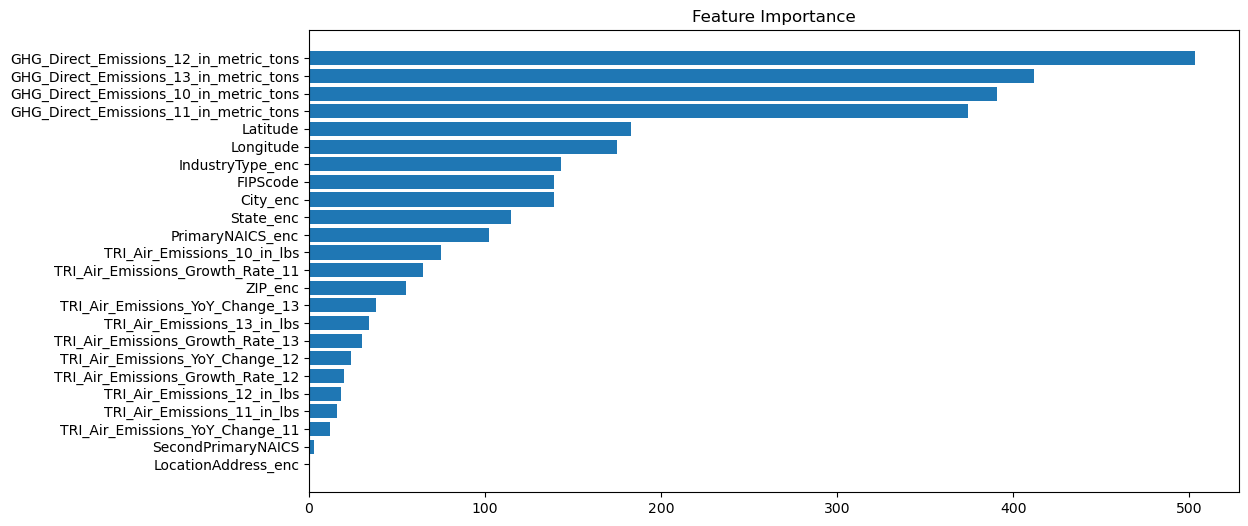

In [128]:

# show the feature importance
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(model, columns):
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    fig = plt.figure(figsize=(12, 6))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(columns)[sorted_idx])
    plt.title('Feature Importance')
    plt.show()

plot_feature_importance(model, numerical_columns)

In [129]:
submit  =  pd.read_csv ( 'sample_submission.csv' ,  header = None ) 
submit [ 1 ]  =  test_predictions 
submit.to_csv( 'submission_5.csv' ,  header = None ,  index = False )